# ColpoNet V2: Integrated Cervical Image Segmentation and Lesion Detection Pipeline

**ColpoNet V2** is an end-to-end AI pipeline for the automated segmentation and detection of cervical lesions in colposcopic images. The system combines:
cts.
- **Detectron2:** Lesion detection (e.g., low/high-grade lesions) restricted to the segmented region.

## Pipeline Overview

1. **Environment setup and model loading**
2. **Segmentation of the analyzable region using SAM**
3. **Image masking or cropping based on the segmentation mask**
4. **Lesion detection within the segmented area using Detectron2**
5. **Filtering of detections outside the analyzable area**
6. **Structured export of results in JSON format**
7. **Optional: Visualization and batch processing**

**Output:**  
For each input image, the pipeline produces a JSON file containing the analyzable region polygon and the coordinates (bounding boxes, masks, or polygons) of each detected lesion, including class labels and confidence scores.

**Technologies:**  
Python 3.8+, PyTorch, Segment Anything Model (SAM), Detectron2, OpenCV, NumPy, Matplotlib, JSON.
alización)
- **JSON** (salida estruct


## 1. Environment Setup and Library Imports

This section ensures all required Python libraries are available and imports them for use throughout the ColpoNet V2 pipeline.  
PyTorch is used for deep learning models, Segment Anything for segmentation, Detectron2 for object detection, and supporting libraries for data handling and visualization.


In [5]:
# 1. Environment Setup and Library Imports

# Core scientific and data handling libraries
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

# PyTorch (Deep Learning)
import torch

# Segment Anything Model (SAM)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Detectron2 (Object Detection)
try:
    import detectron2
    from detectron2.engine import DefaultPredictor
    from detectron2.config import get_cfg
    from detectron2 import model_zoo
except ImportError:
    print("Detectron2 is not installed. Please install it to enable lesion detection.")

# Utility for polygon operations (Optional)
from shapely.geometry import Polygon, Point


## 2. Image Loading and Visualization

In this section, we will load the sample images from our dataset folder to prepare for processing with ColpoNet. The goal is to ensure that all images are read correctly and are available for subsequent segmentation and detection steps.

**Steps:**
1. List all image files in the specified directory.
2. Read each image using OpenCV.
3. Display sample images for visual inspection.

> ⚠️ _Make sure your image folder path is correct (e.g., `"ColpoNetV2/sample_images/"`). Adjust as needed for your setup._


Found 8 images in Muestra/


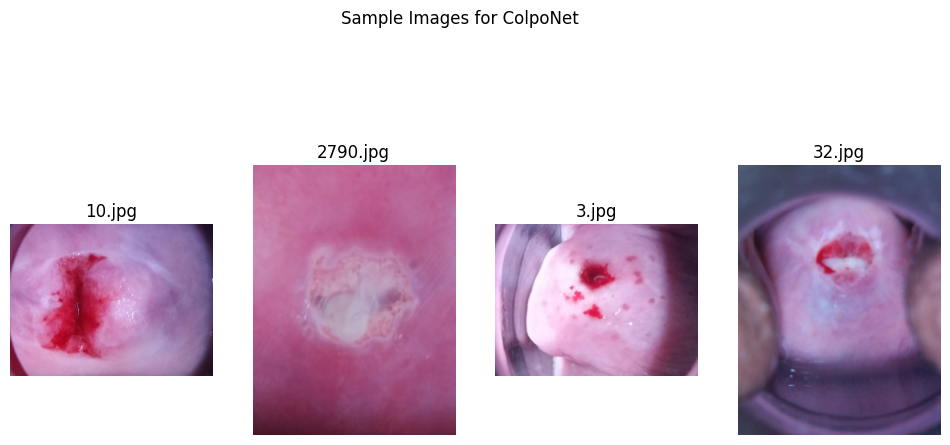

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

# 1. Set the image directory
IMAGE_DIR = "Muestra/"  # Update this path as needed

# 2. List all image files
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Found {len(image_files)} images in {IMAGE_DIR}")

# 3. Load images into a list
images = []
for file in image_files:
    img_path = os.path.join(IMAGE_DIR, file)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for matplotlib
        images.append((file, img))
    else:
        print(f"Warning: {file} could not be loaded.")

# 4. Visualize the first 4 images
n_samples = min(4, len(images))
plt.figure(figsize=(12, 6))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(images[i][1])
    plt.title(images[i][0])
    plt.axis('off')
plt.suptitle("Sample Images for ColpoNet")
plt.show()


## 3. Automatic Segmentation 

**Steps:**
1. Load the pre-trained SAM model and its checkpoint.
2. Apply automatic mask generator to each image.
3. Store and display the generated masks for quality control.

> ⚠️ _Ensure you have the correct model checkpoint (e.g., `sam_vit_b_01ec64.pth`). Adjust the `MODEL_TYPE` and `CHECKPOINT_PATH` variables according to your downloaded weights._


In [7]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import numpy as np
import time

# 1. Load your images (REPLACE this with your real code!)
# Example: images = [("img1.jpg", img_array1), ...]
print("Loading images...")
try:
    print(f"Number of images loaded: {len(images)}")
    for idx, (fname, img) in enumerate(images):
        print(f"  [{idx+1}] {fname} | shape: {img.shape}")
except Exception as e:
    print("Error: Variable 'images' not defined or not in the expected format.")
    raise

# 2. Set model and checkpoint path
MODEL_TYPE = "vit_b"  # or "vit_l", "vit_h"
CHECKPOINT_PATH = "models/sam_vit_b_01ec64.pth"
print(f"Loading SAM model '{MODEL_TYPE}' from checkpoint '{CHECKPOINT_PATH}' ...")
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
mask_generator = SamAutomaticMaskGenerator(sam)
print("SAM model loaded.")

# 3. Generate masks for each image
all_masks = []
print("Starting mask generation (this may take time)...")
for idx, (fname, img) in enumerate(images):
    print(f"Processing {fname} [{idx+1}/{len(images)}]...")
    t0 = time.time()
    try:
        masks = mask_generator.generate(img)
        elapsed = time.time() - t0
        print(f"  -> {len(masks)} regions found in {elapsed:.2f} seconds.")
    except Exception as e:
        print(f"  ERROR processing {fname}: {e}")
        masks = []
    all_masks.append({
        "file": fname,
        "masks": masks
    })

print("\n--- SUMMARY ---")
for m in all_masks:
    print(f"{m['file']}: {len(m['masks'])} masks.")

# 4. Visualize masks on the first image (optional)
from matplotlib import pyplot as plt
import cv2

def show_masks_on_image(img, masks, alpha=0.5):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    any_drawn = False
    for mask in masks:
        m = mask['segmentation']
        if isinstance(m, np.ndarray) and m.ndim == 2:
            contours, _ = cv2.findContours((m * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt = cnt.squeeze()
                if cnt.ndim == 2:
                    plt.plot(cnt[:, 0], cnt[:, 1], linewidth=2, alpha=alpha)
                    any_drawn = True
    plt.axis('off')
    plt.title("SAM Masks Overlay")
    plt.show()
    if not any_drawn:
        print("No contours drawn. Mask may be empty.")





Loading images...
Number of images loaded: 8
  [1] 10.jpg | shape: (3096, 4128, 3)
  [2] 2790.jpg | shape: (4128, 3096, 3)
  [3] 3.jpg | shape: (3096, 4128, 3)
  [4] 32.jpg | shape: (4128, 3096, 3)
  [5] 3946.jpg | shape: (4128, 3096, 3)
  [6] 564.jpg | shape: (4128, 3096, 3)
  [7] 608.jpg | shape: (4128, 3096, 3)
  [8] 874.jpg | shape: (4128, 3096, 3)
Loading SAM model 'vit_b' from checkpoint 'models/sam_vit_b_01ec64.pth' ...
SAM model loaded.
Starting mask generation (this may take time)...
Processing 10.jpg [1/8]...
  -> 8 regions found in 73.65 seconds.
Processing 2790.jpg [2/8]...
  -> 6 regions found in 76.47 seconds.
Processing 3.jpg [3/8]...
  -> 22 regions found in 78.57 seconds.
Processing 32.jpg [4/8]...
  -> 11 regions found in 74.52 seconds.
Processing 3946.jpg [5/8]...
  -> 11 regions found in 65.00 seconds.
Processing 564.jpg [6/8]...
  -> 14 regions found in 65.93 seconds.
Processing 608.jpg [7/8]...
  -> 13 regions found in 69.42 seconds.
Processing 874.jpg [8/8]...
  

Visualizing [1] 10.jpg with 8 masks...


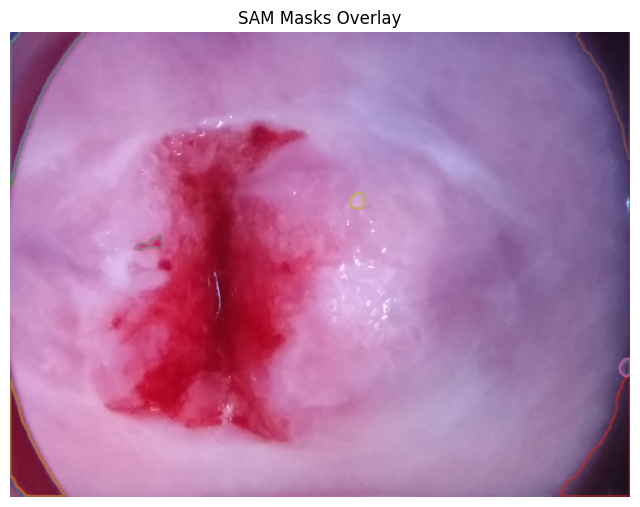

Visualizing [2] 2790.jpg with 6 masks...


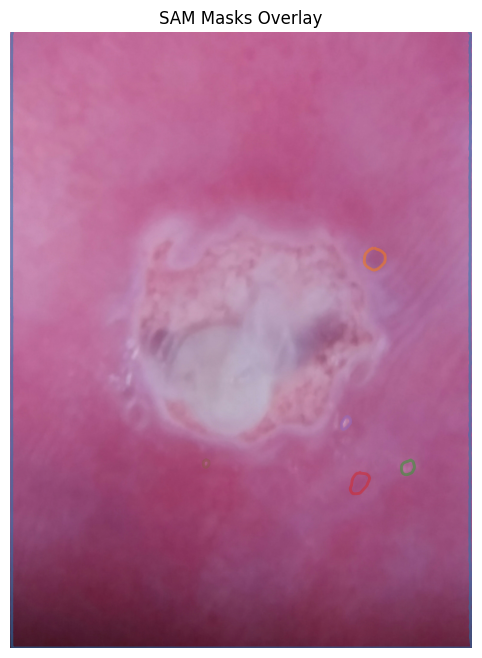

Visualizing [3] 3.jpg with 22 masks...


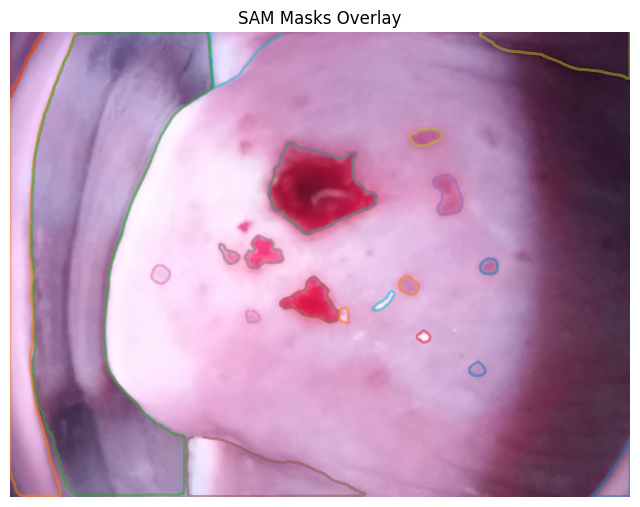

Visualizing [4] 32.jpg with 11 masks...


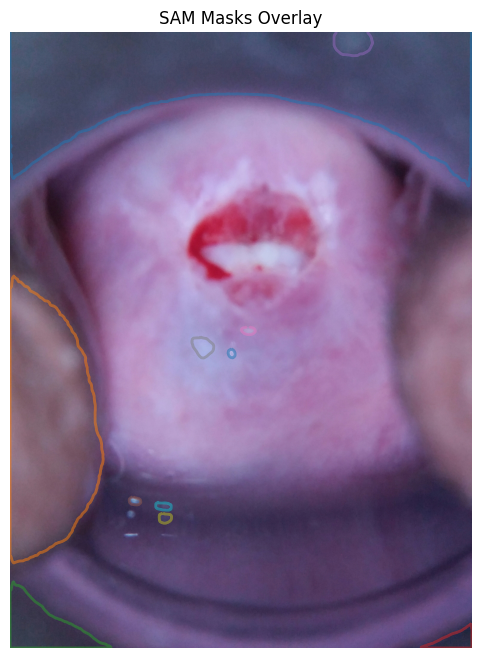

Visualizing [5] 3946.jpg with 11 masks...


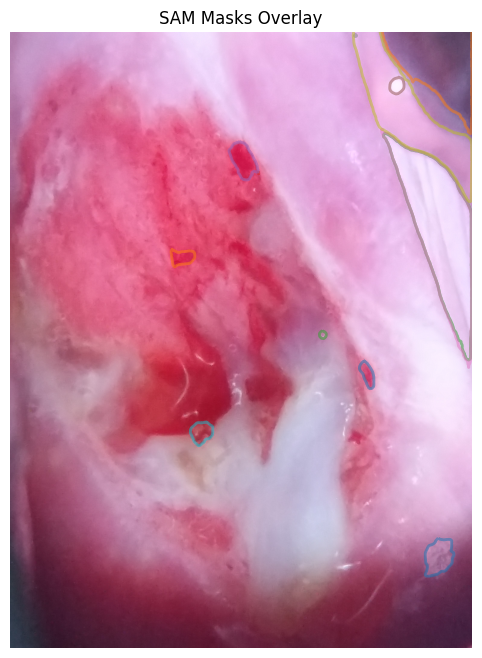

Visualizing [6] 564.jpg with 14 masks...


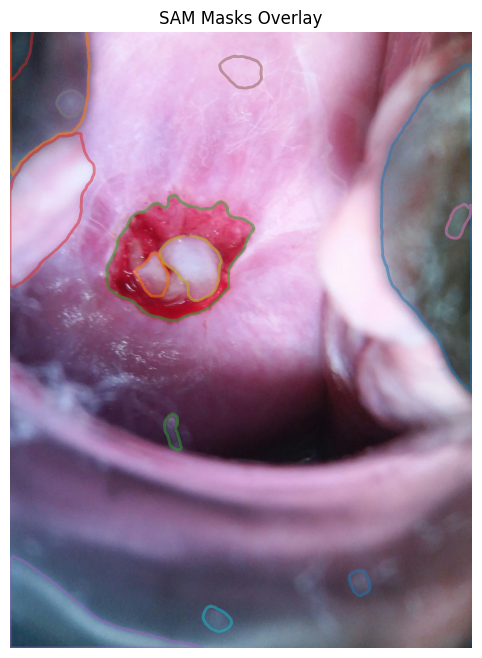

Visualizing [7] 608.jpg with 13 masks...


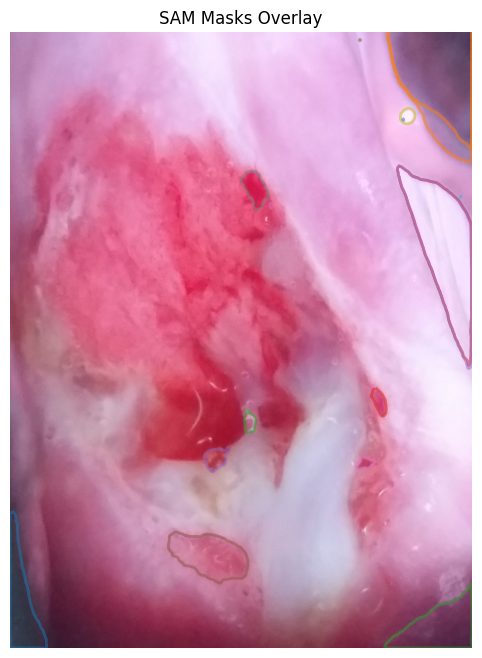

Visualizing [8] 874.jpg with 25 masks...


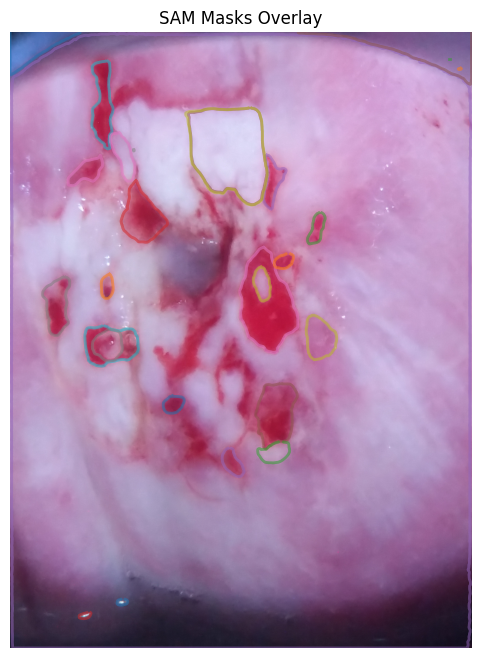

In [8]:

# Visualize masks for ALL images
for idx, imgdata in enumerate(all_masks):
    masks = imgdata["masks"]
    fname = imgdata["file"]
    if len(masks) > 0 and "segmentation" in masks[0]:
        print(f"Visualizing [{idx+1}] {fname} with {len(masks)} masks...")
        show_masks_on_image(images[idx][1], [m for m in masks if "segmentation" in m])
    else:
        print(f"No masks or segmentation found in {fname}.")


In [11]:
import os

output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)
def save_masks_on_image(img, masks, save_path, alpha=0.5):
    import matplotlib.pyplot as plt
    import numpy as np
    import cv2

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    any_drawn = False
    for mask in masks:
        m = mask['segmentation']
        if isinstance(m, np.ndarray) and m.ndim == 2:
            contours, _ = cv2.findContours((m * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt = cnt.squeeze()
                if cnt.ndim == 2:
                    plt.plot(cnt[:, 0], cnt[:, 1], linewidth=2, alpha=alpha)
                    any_drawn = True
    plt.axis('off')
    plt.title("SAM Masks Overlay")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    if not any_drawn:
        print(f"No contours drawn for {save_path}. Mask may be empty.")


In [12]:
for idx, imgdata in enumerate(all_masks):
    masks = imgdata["masks"]
    fname = imgdata["file"]
    out_path = os.path.join(output_dir, f"seg_{os.path.splitext(fname)[0]}.png")
    if len(masks) > 0 and "segmentation" in masks[0]:
        print(f"Saving [{idx+1}] {fname} with {len(masks)} masks to {out_path} ...")
        save_masks_on_image(images[idx][1], [m for m in masks if "segmentation" in m], out_path)
    else:
        print(f"No masks or segmentation found in {fname}, not saving image.")


Saving [1] 10.jpg with 8 masks to outputs/seg_10.png ...
Saving [2] 2790.jpg with 6 masks to outputs/seg_2790.png ...
Saving [3] 3.jpg with 22 masks to outputs/seg_3.png ...
Saving [4] 32.jpg with 11 masks to outputs/seg_32.png ...
Saving [5] 3946.jpg with 11 masks to outputs/seg_3946.png ...
Saving [6] 564.jpg with 14 masks to outputs/seg_564.png ...
Saving [7] 608.jpg with 13 masks to outputs/seg_608.png ...
Saving [8] 874.jpg with 25 masks to outputs/seg_874.png ...
